# Deep Learning入門

## CNN

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
from IPython.display import SVG
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10, fashion_mnist
from tensorflow.keras.layers import (Activation, Add, BatchNormalization,
                                     Conv2D, Dense, Dropout, Flatten, Input,
                                     MaxPooling2D, add)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils.vis_utils import model_to_dot

%matplotlib inline

random_state = 42

## 畳み込み層 パディング サンプル

In [2]:
# サンプル画像 (5x5)
sample_image = np.array([[1, 1, 1, 0, 0],
                         [0, 1, 1, 1, 0],
                         [0, 0, 1, 1, 1],
                         [0, 0, 1, 1, 0],
                         [0, 1, 1, 0, 0]]
                        ).astype('float32').reshape(1, 5, 5, 1)

# フィルタ
W = np.array([[1, 0, 1],
              [0, 1, 0],
              [1, 0, 1]]).astype('float32').reshape(3, 3, 1, 1)

model = Sequential()

model.add(Conv2D(1, kernel_size=(3, 3), strides=(1, 1),
                 padding='valid', input_shape=(5, 5, 1), use_bias=False))
model.layers[0].set_weights([W])

model.predict(sample_image).reshape(3, 3)

array([[4., 3., 4.],
       [2., 4., 3.],
       [2., 3., 4.]], dtype=float32)

## プーリング層 ストライド サンプル

In [3]:
# サンプル画像
sample_image = np.array([[1, 1, 2, 4],
                         [5, 6, 7, 8],
                         [3, 2, 1, 0],
                         [1, 2, 3, 4]]
                        ).astype("float32").reshape(1, 4, 4, 1)

model = Sequential()

model.add(MaxPooling2D(pool_size=(2, 2), strides=None,
                       padding='valid', input_shape=(4, 4, 1)))

model.predict(sample_image).reshape(2, 2)

array([[6., 8.],
       [3., 4.]], dtype=float32)

## データセット読み込み

| ラベル | クラス                        |
| ---    | ---                           |
| 0      | T-シャツ/トップ (T-shirt/top) |
| 1      | ズボン (Trouser)              |
| 2      | プルオーバー (Pullover)       |
| 3      | ドレス (Dress)                |
| 4      | コート (Coat)                 |
| 5      | サンダル (Sandal)             |
| 6      | シャツ (Shirt)                |
| 7      | スニーカー (Sneaker)          |
| 8      | バッグ (Bag)                  |
| 9      | アンクルブーツ (Ankle boot)   |

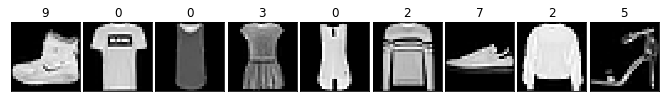

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.set_title(str(y_train[i]))
    ax.imshow(x_train[i], cmap='gray')

## 前処理

CNNでは2次元の画像として処理していくために
4次元テンソル (バッチサイズ、縦の画素数、横の画素数、チャンネル数)として扱う。
チャンネル数は白黒画像の場合は1、 カラー画像の場合はRGBで3。

In [5]:
x_train.shape

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)) / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train.shape

(60000, 28, 28, 1)

## モデル作成

In [6]:
model = Sequential()

# 入力画像 28x28x1 (縦の画素数)x(横の画素数)x(チャンネル数)
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal', input_shape=(28, 28, 1)))  # 28x28x1 -> 24x24x16
model.add(MaxPooling2D(pool_size=(2, 2)))  # 24x24x16 -> 12x12x16
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal'))  # 12x12x16 -> 8x8x64
model.add(MaxPooling2D(pool_size=(2, 2)))  # 8x8x64 -> 4x4x64

model.add(Flatten())  # 4x4x64-> 1024
model.add(Dense(10, activation='softmax'))  # 1024 -> 10

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['acc']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          25664     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 36,330
Trainable params: 36,330
Non-trainable params: 0
__________________________________________________

## モデル可視化

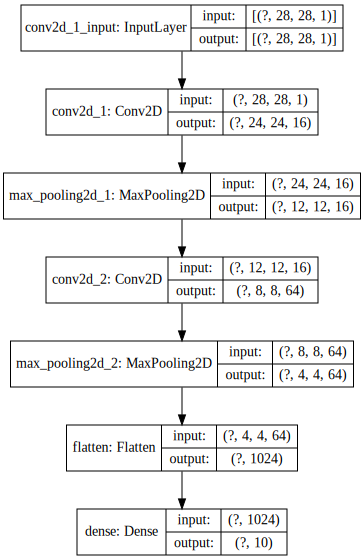

In [7]:
SVG(model_to_dot(model, dpi=72, show_shapes=True).create(prog='dot', format='svg'))

## モデル学習

In [8]:
early_stopping = EarlyStopping(patience=1, verbose=1)
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, verbose=1,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 31s 518us/sample - loss: 0.5504 - acc: 0.8056 - val_loss: 0.4163 - val_acc: 0.8500
Epoch 2/100
60000/60000 [==============================] - 30s 499us/sample - loss: 0.3601 - acc: 0.8731 - val_loss: 0.3603 - val_acc: 0.8707
Epoch 3/100
60000/60000 [==============================] - 30s 500us/sample - loss: 0.3179 - acc: 0.8880 - val_loss: 0.3381 - val_acc: 0.8789
Epoch 4/100
60000/60000 [==============================] - 30s 500us/sample - loss: 0.2859 - acc: 0.8990 - val_loss: 0.3158 - val_acc: 0.8873
Epoch 5/100
60000/60000 [==============================] - 30s 499us/sample - loss: 0.2669 - acc: 0.9046 - val_loss: 0.2961 - val_acc: 0.8957
Epoch 6/100
60000/60000 [==============================] - 30s 502us/sample - loss: 0.2475 - acc: 0.9123 - val_loss: 0.2942 - val_acc: 0.8953
Epoch 7/100
60000/60000 [==============================] - 30s 503us/sample - loss: 0.2315 - acc: 

## モデル評価

Test loss: 0.2929254972815514
Test accuracy: 0.8961


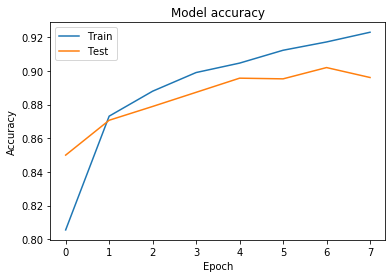

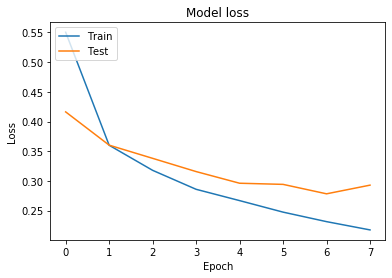

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()